# Superhero Name Generator using Tensorlflow

In [1]:
#Importing the dataset to be used
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [3]:
#Assigning a variable to be used globally within the notebook
with open('superhero/superheroes.txt', 'r') as f:
  dataset = f.read()

dataset[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [9]:
#Imprt necessary libraries
import tensorflow as tf
from six import indexbytes

In [10]:
print(tf.__version__)

2.8.2


In [5]:
#Creating a tokenizer from tensorflow library
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [6]:
tokenizer.fit_on_texts(dataset)

In [11]:
char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


In [12]:
#Converting between names and sequences
names = dataset.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [13]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [14]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0]for c in name]

In [15]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [16]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i != 0])

In [17]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

In [19]:
#creating sequences
sequences = []

for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2:
    sequences += [seq[:i] for i in range(2, len(seq) + 1)]

In [20]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [22]:
#Print maximum length of sequences within the created sequences
max_len = max([len (x) for x in sequences])
print(max_len)

33


In [23]:
#Padding all sequences
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='pre',
                                                                maxlen = max_len)
print(padded_sequence[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [25]:
#Display shape of the created and padded sequences
padded_sequence.shape


(88279, 33)

Creating training and validation sets

In [26]:
x , y = padded_sequence[:, :-1], padded_sequence[:,-1]
print(x.shape, y.shape)

(88279, 32) (88279,)


In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

print(x_train.shape, y_train.shape)
print(x_test.shape , y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [28]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars)

29


 Creating the Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense

model = Sequential([ Embedding(num_chars , 8,input_length= max_len-1),
                    Conv1D(64, 5, strides=1, activation='tanh',padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars, activation = 'softmax')])


model.compile( loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
____________________________________________________

 Training the Model

In [30]:
h = model.fit(x_train, y_train,
              validation_data= (x_test, y_test),
              epochs =50, verbose =2,
              callbacks= [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)])


Epoch 1/50
2070/2070 - 24s - loss: 2.7389 - accuracy: 0.1896 - val_loss: 2.5827 - val_accuracy: 0.2251 - 24s/epoch - 12ms/step
Epoch 2/50
2070/2070 - 12s - loss: 2.5265 - accuracy: 0.2389 - val_loss: 2.5015 - val_accuracy: 0.2440 - 12s/epoch - 6ms/step
Epoch 3/50
2070/2070 - 11s - loss: 2.4598 - accuracy: 0.2583 - val_loss: 2.4485 - val_accuracy: 0.2610 - 11s/epoch - 6ms/step
Epoch 4/50
2070/2070 - 10s - loss: 2.4147 - accuracy: 0.2715 - val_loss: 2.4214 - val_accuracy: 0.2710 - 10s/epoch - 5ms/step
Epoch 5/50
2070/2070 - 11s - loss: 2.3814 - accuracy: 0.2806 - val_loss: 2.3931 - val_accuracy: 0.2780 - 11s/epoch - 5ms/step
Epoch 6/50
2070/2070 - 11s - loss: 2.3524 - accuracy: 0.2878 - val_loss: 2.3678 - val_accuracy: 0.2843 - 11s/epoch - 5ms/step
Epoch 7/50
2070/2070 - 11s - loss: 2.3260 - accuracy: 0.2982 - val_loss: 2.3479 - val_accuracy: 0.2916 - 11s/epoch - 5ms/step
Epoch 8/50
2070/2070 - 11s - loss: 2.3009 - accuracy: 0.3055 - val_loss: 2.3272 - val_accuracy: 0.2987 - 11s/epoch - 

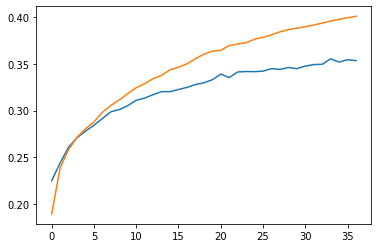

In [31]:
import matplotlib.pyplot as plt

epoch_ran = len(h.history['loss']) 

plt.plot(range(0 , epoch_ran), h.history['val_accuracy'], label='validation')
plt.plot(range(0 , epoch_ran), h.history['accuracy'], label='training')
plt.show()

 Generating example superhero names.

In [36]:
def generate_names(seed):
  for i in range(0, 40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding= 'pre',
                                                           maxlen = max_len -1,
                                                           truncating ='pre')
    
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break
  print(seed)

In [37]:
generate_names('f')

fing shark	
